In [1]:
import cantera as ct
import cantera.ck2cti as ck2cti
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

## Converting from Chemkin

One of the most common problems that users encounter is converting CHEMKIN format input files to Cantera CTI format. Unfortunately, the CHEMKIN interpreter for these files is not very strict about complying with its own standard, so files that work just fine in CHEMKIN require some massaging to work with Cantera. Let's look at one example:

In [2]:
# command line equivalent:
# python -m cantera.ck2cti --input=mech.txt --thermo=thermo.txt --transport=tran.txt --permissive --out=mech.cti
parser = ck2cti.Parser()
parser.convertMech('mech_debug/mech.txt', 'mech_debug/thermo.txt', 'mech_debug/tran.txt', outName='mech_debug/mech.cti')

ERROR: Unable to parse 'mech_debug/mech.txt' near line 73:



InputParseError: Unrecognized token on REACTIONS line, 'BASE'

In [3]:
parser = ck2cti.Parser()
parser.convertMech('mech_debug/mech_fixed.txt', 'mech_debug/thermo.txt', 'mech_debug/tran.txt', outName='mech_debug/mech.cti')

INFO:root:Skipping unexpected species "C3H4CY" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "C4H5" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CH3NO3" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CH2NO3" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "HCCOH" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "N2O5" while reading thermodynamics entry.
INFO:root:Error while reading thermo entry starting on line 523:
"""
TC4H7             A 8/83C   4H	 7    0    0G   300.     3000.	  1500.        1
 0.4219753E 01  0.2882451E-01 -0.1399213E-04  0.3340718E-08 -0.3226427E-12     2
 0.1266295E 05  0.3253111E 01 -0.2152314E+01  0.5547424E-01 -0.6226715E-04     3
 0.4593056E-07 -0.1492297E-10  0.1407443E 05  0.3421103E 02  0.1543086E+05     4
"""
ERROR: Unable to parse 'mech_debug/thermo.txt' near line 526:



ValueError: could not convert string to float: 'E-08 -0.32'

In [4]:
parser = ck2cti.Parser()
parser.convertMech('mech_debug/mech_fixed.txt', 'mech_debug/thermo_fixed.txt', 'mech_debug/tran.txt', outName='mech_debug/mech.cti')

INFO:root:Skipping unexpected species "C3H4CY" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "C4H5" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CH3NO3" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CH2NO3" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "HCCOH" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "N2O5" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "TC4H7" while reading thermodynamics entry.


InputParseError: Ignoring duplicate transport data for species "NCN" on line 152 of "mech_debug/tran.txt".

In [5]:
parser = ck2cti.Parser()
parser.convertMech('mech_debug/mech_fixed.txt', 'mech_debug/thermo_fixed.txt', 'mech_debug/tran.txt', permissive=True, outName='mech_debug/mech.cti')

INFO:root:Skipping unexpected species "C3H4CY" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "C4H5" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CH3NO3" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CH2NO3" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "HCCOH" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "N2O5" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "TC4H7" while reading thermodynamics entry.


Wrote CTI mechanism file to 'mech_debug/mech.cti'.
Mechanism contains 129 species and 1231 reactions.


[]

We have compiled a list of the most common errors in CHEMKIN format input files, which you can find in our documentation: https://cantera.org/tutorials/ck2cti-tutorial.html#debugging-common-errors-in-ck-files

## Thermo Data

Another common situation is when loading a CTI file, you encounter warnings about discontinuities in the thermodynamic data.

In [6]:
gas = ct.Solution('mech_debug/mech.cti')



**** WARNING ****
For species HCNH, discontinuity in cp/R detected at Tmid = 1500
	Value computed using low-temperature polynomial:  14.1403
	Value computed using high-temperature polynomial: 8.62009


**** WARNING ****
For species HCNH, discontinuity in h/RT detected at Tmid = 1500
	Value computed using low-temperature polynomial:  31.9298
	Value computed using high-temperature polynomial: 31.3834


**** WARNING ****
For species HCNH, discontinuity in s/R detected at Tmid = 1500
	Value computed using low-temperature polynomial:  38.9438
	Value computed using high-temperature polynomial: 38.3468


**** WARNING ****
For species H2CNO, discontinuity in cp/R detected at Tmid = 1500
	Value computed using low-temperature polynomial:  22.7915
	Value computed using high-temperature polynomial: 11.3588


**** WARNING ****
For species H2CNO, discontinuity in h/RT detected at Tmid = 1500
	Value computed using low-temperature polynomial:  26.491
	Value computed using high-temperature polynomial

These warnings are part of a validation check that Cantera does to make sure the thermodynamics data are consistent. In the standard NASA 14-coefficient polynomial form, the thermodynamics data are defined as two five coefficient polynomials (plus two other constants) over two temperature ranges. This is the form used for CHEMKIN files. The discontinuities occur when either the slope or the value of the thermodynamic functions ($c_p/R$, $h/(RT)$, or $s/R$) has a discontinuity at the mid-point temperature. Most commonly, one or more the discontinuities are due to incorrectly fit parameters, but they can also be caused by other means. Let's investigate.

In [7]:
ct.suppress_thermo_warnings()

<IPython.core.display.Javascript object>


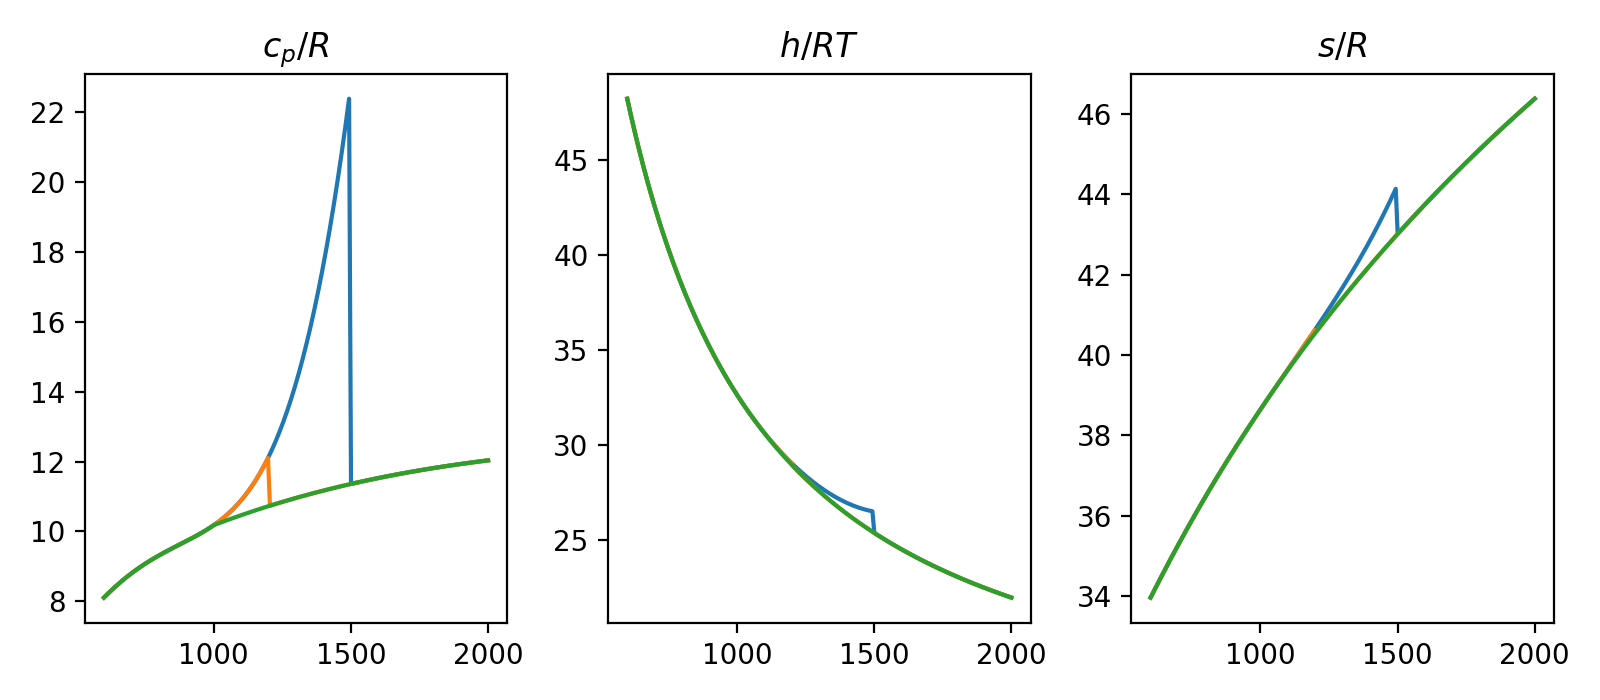

In [8]:
sp = gas.species('H2CNO')
T = np.linspace(600, 2000, 200)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
    f.tight_layout()
plot_thermo(sp.thermo)

In [10]:
c0 = sp.thermo.coeffs
c0

array([ 1.5000000e+03,  5.4028152e+00,  6.9057001e-03, -2.5162977e-06,
        4.1014066e-10, -2.4718300e-14,  2.4528690e+04, -4.4574262e+00,
        3.8781858e+00, -6.6530886e-03,  5.3947610e-05, -6.8176813e-08,
        2.7181746e-11,  2.5716857e+04,  7.4618774e+00])

In [11]:
c0[0] = 1200
test = ct.NasaPoly2(sp.thermo.min_temp, sp.thermo.max_temp, sp.thermo.reference_pressure, c0)
plot_thermo(test)

In [12]:
c0[0] = 1000
test = ct.NasaPoly2(sp.thermo.min_temp, sp.thermo.max_temp, sp.thermo.reference_pressure, c0)
plot_thermo(test)

In many cases, when the change is on the order of a few percent, these discontinuities won't cause problems. However, if you notice a simulation failing at a consistent temperature for several conditions, this is one possible cause.

## Reaction Rates

Another common issue with mechanisms are unphysical reaction rates (particularly reverse reaction rates). These unphysical reaction rates often exceed the collision limit for a given reaction. A recent study by [Chen et al.](https://www.sciencedirect.com/science/article/pii/S0010218017303024) found that

> among.. 20 [recent] models tested, 15 of them contain either considerable numbers of rate coefficients that exceed their respective collision limits or reactions exceeding the collision limit in a considerable manner. In the worst case, the rate coefficient exceeds the collision limit by 73 orders of magnitude.

The authors continue

> It is proposed that computational tools should be made available for authors to conduct the same rate coefficient screening.

Let's take a look at how Cantera can fill this need.

In [13]:
gas.TPX = 300, 101325, 'CH4:1.0, O2:0.1'
gas.equilibrate('TP')
gas()


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         0.71061  kg/m^3
  mean mol. weight         17.4932  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -5.9584e+06       -1.042e+08     J
   internal energy      -6.101e+06       -1.067e+08     J
           entropy           10981        1.921e+05     J/K
    Gibbs function     -9.2527e+06       -1.619e+08     J
 heat capacity c_p          2036.8        3.563e+04     J/K
 heat capacity c_v          1561.5        2.732e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2    7.59247e-06      8.74939e-07         -27.5055
               H2O       0.090905        0.0936178         -122.058
                CO    4.06301e-11      6.50574e-11         -92.0113
               CO2      0.04

<IPython.core.display.Javascript object>


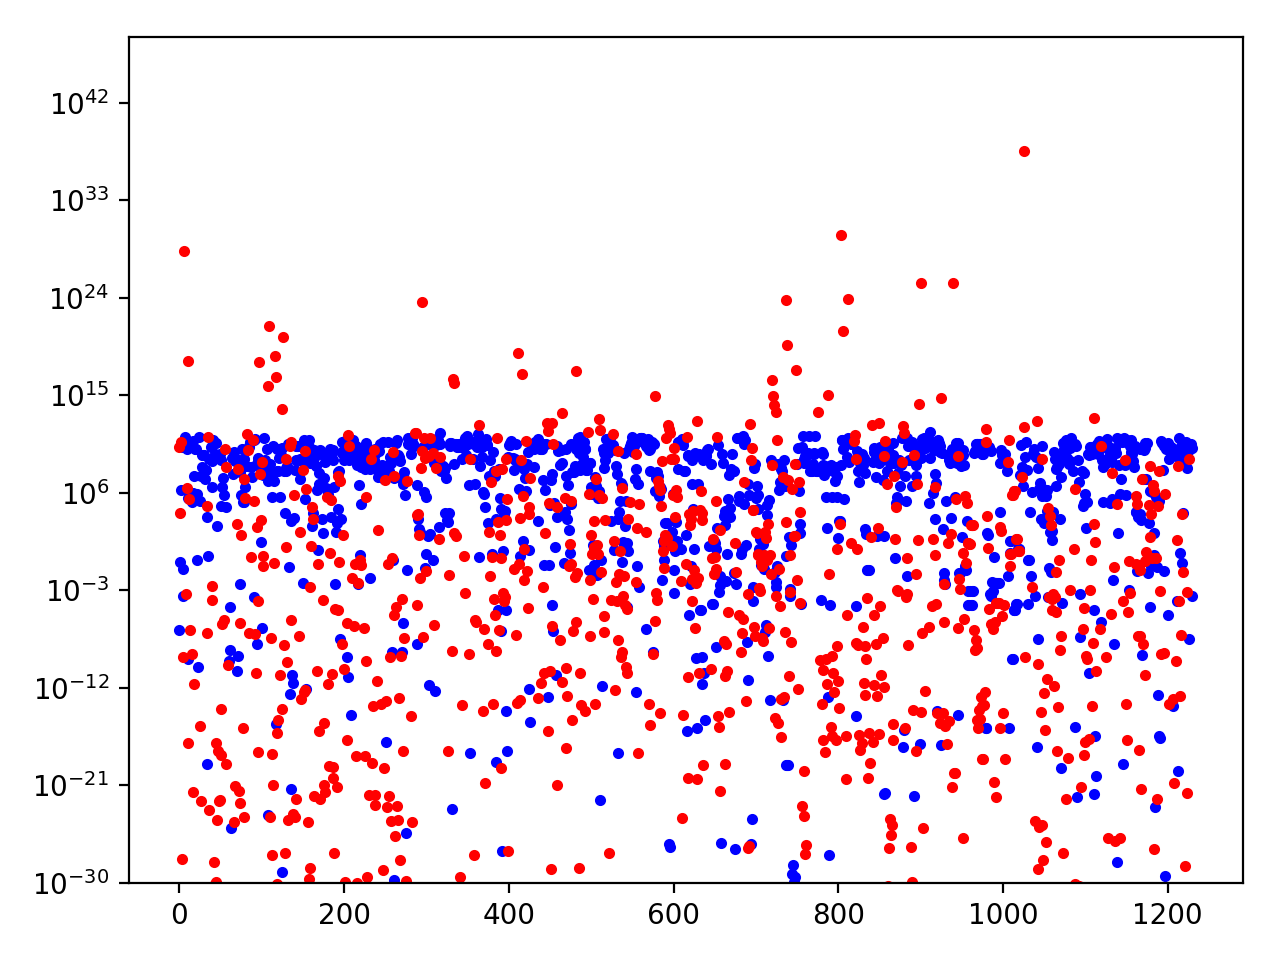

In [15]:
f,ax = plt.subplots(1,1)
ax.semilogy(gas.forward_rate_constants, 'b.')
ax.semilogy(gas.reverse_rate_constants, 'r.')
ax.set_ylim(bottom=1e-30)
f.tight_layout()

There are clearly several reverse rates with very high magnitudes. Let's print the reactions with reverse rate constants higher than $10^{20}$:

In [16]:
kr = gas.reverse_rate_constants
for i, k in enumerate(kr):
    if k > 1e20:
        print(i, k, gas.reaction_equation(i))

6 2.0744428930843393e+28 HNCN + M <=> H + NCN + M
109 2.2719505890490702e+21 N2H2 + M <=> 2 NH + M
126 2.1338441361785828e+20 N2H4 + M <=> H + N2H3 + M
295 4.265672038538968e+23 CH3 + M <=> CH + H2 + M
737 5.805313218928237e+23 C3H6 + O2 <=> HO2 + SC3H5
803 6.711657999076253e+29 C3H3 + H <=> C3H2 + H2
806 7.617192466422548e+20 C3H3 + OH <=> C3H2 + H2O
812 7.218823549677307e+23 C2H2 + CH <=> C3H2 + H
900 2.1230833091010194e+25 C4H2 (+M) <=> C4H + H (+M)
939 2.1370065396257623e+25 PC3H4 <=> C2H + CH3
1026 3.303061070110949e+37 C2N2 + M <=> 2 CN + M


Among these is the reaction 

$$\text{CH}_3 + \text{M} <=> \text{CH} + \text{H2} + \text{M}$$

with reverse rate constant of `4.2656e+23`. This is a pretty common reaction, so we can compare to the same reaction from, for example, GRI-30:

In [17]:
gri = ct.Solution('gri30.cti')
for i, r in enumerate(gri.reactions()):
    if 'CH3' in r and 'H2' in r and 'CH' in r:
        print(i, r)

288 CH + H2 (+M) <=> CH3 (+M)


The reaction is #295 from the first mechanism and #288 from GRI-30, so we can calculate the rate of each reaction over a range of temperatures from 300 K to 3000 K and plot them.

<IPython.core.display.Javascript object>


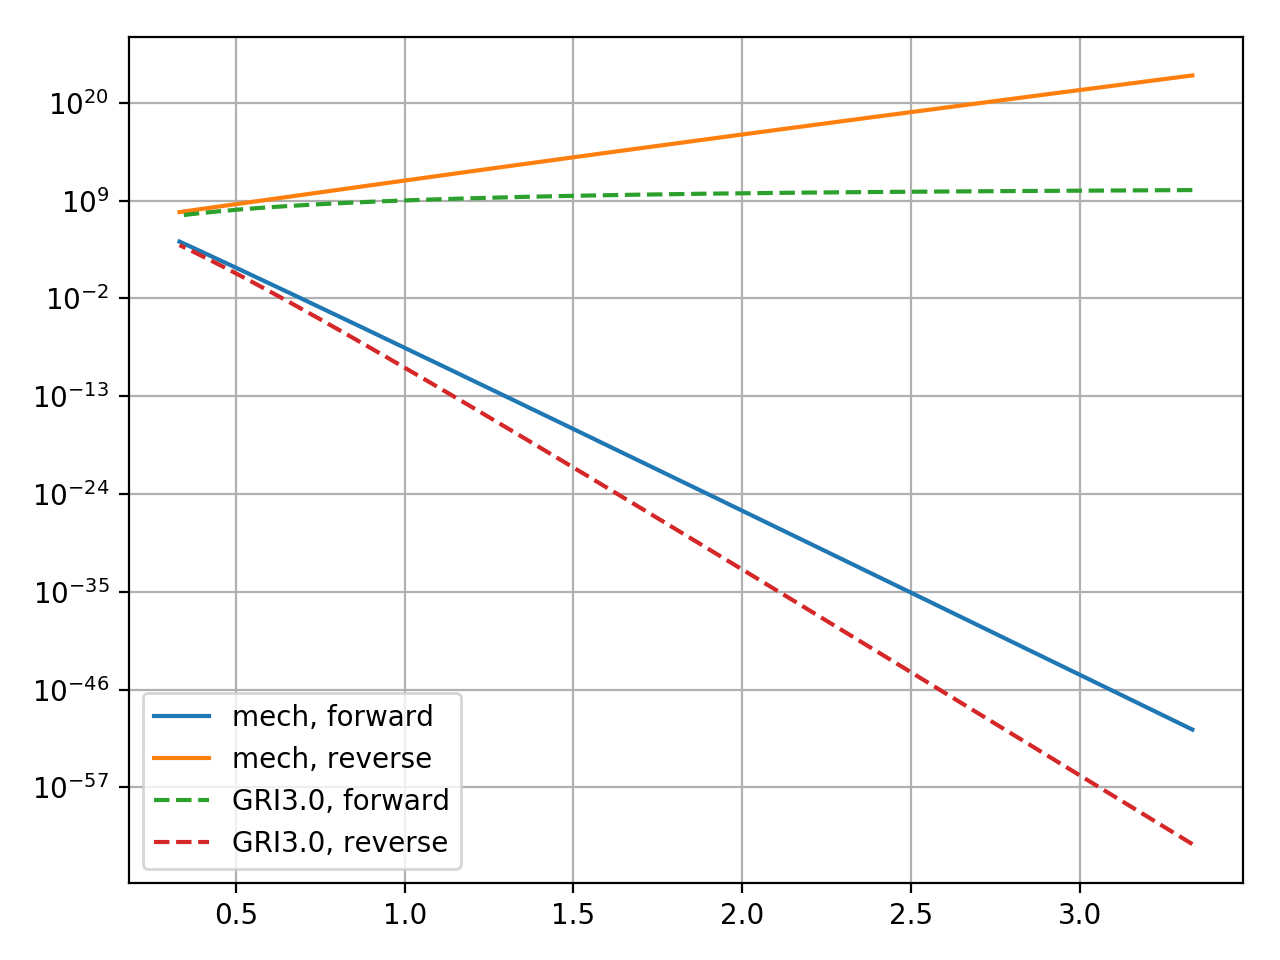

In [18]:
gasN = ct.SolutionArray(gas, shape=200)
griN = ct.SolutionArray(gri, shape=200)
T = np.linspace(300, 3000, 200)
gasN.TPY = T, 101325, 'N2:1.0'
griN.TPY = T, 101325, 'N2:1.0'

f,ax = plt.subplots(1, 1)
ax.semilogy(1000/T, gasN.forward_rate_constants[:,295], label='mech, forward')
ax.semilogy(1000/T, gasN.reverse_rate_constants[:,295], label='mech, reverse')
ax.semilogy(1000/T, griN.forward_rate_constants[:,288], '--', label='GRI3.0, forward')
ax.semilogy(1000/T, griN.reverse_rate_constants[:,288], '--', label='GRI3.0, reverse')
ax.legend(loc='best')
ax.grid(True)
f.tight_layout()

Here, we see that the rate of the reactions is close-ish at high temperature (>1000 K), but as the temperature decreases, they rapidly diverge and differ by 11 orders of magnitude at 300 K. This can cause problems in the integrator for both 0-D and 1-D problems, often accompanied by error messages about "Repeated recoverable right-hand side errors"